In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import plotly.express as px
from fredapi import Fred

In [2]:
fred_key = "a6c1fee464741e98bc653f5c59b46426"
fred = Fred(api_key = fred_key)

#### **Shape of the Yield Curve**

In [3]:
treasury_yields = ["DGS3MO","DGS6MO","DGS1","DGS2","DGS3","DGS3","DGS5","DGS7","DGS10","DGS20","DGS30"]

yields = pd.DataFrame()
for tbill in treasury_yields: 
    series = fred.get_series(tbill)
    df = series.to_frame(name = tbill)
    yields = pd.concat([yields,df],axis = 1)

In [4]:
yields = yields.dropna()
yields

,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
1981-09-01,17.01,17.17,17.06,16.78,16.57,16.57,16.12,15.71,15.41,15.09,14.70
1981-09-02,16.65,17.32,17.16,16.78,16.43,16.43,16.09,15.75,15.40,15.11,14.70
1981-09-03,16.96,17.42,17.31,16.90,16.48,16.48,16.14,15.78,15.48,15.21,14.82
1981-09-04,16.64,17.37,17.24,16.89,16.52,16.52,16.17,15.86,15.51,15.24,14.84
1981-09-08,16.54,17.43,17.29,16.95,16.56,16.56,16.23,15.92,15.59,15.36,14.99
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-12,5.06,4.68,4.09,3.64,3.47,3.47,3.47,3.57,3.68,4.07,4.00
2024-09-13,4.97,4.60,4.00,3.57,3.42,3.42,3.43,3.53,3.66,4.05,3.98
2024-09-16,4.96,4.55,3.96,3.56,3.42,3.42,3.41,3.51,3.63,4.01,3.94
2024-09-17,4.95,4.55,3.99,3.59,3.45,3.45,3.44,3.53,3.65,4.02,3.96


In [5]:
import plotly.graph_objs as go
from datetime import datetime, timedelta

# Assume 'today' is the current date. Replace with the actual date if necessary.
today = datetime.today()

# Create a list of the legend names with dynamic dates
legend_names = [
    f"Today ({today.strftime('%Y-%m-%d')})",
    f"One week ago ({(today - timedelta(days=7)).strftime('%Y-%m-%d')})",
    f"30 days ago ({(today - timedelta(days=30)).strftime('%Y-%m-%d')})",
    f"180 days ago ({(today - timedelta(days=180)).strftime('%Y-%m-%d')})"
]

# Define a list of colors for the lines
line_colors = ['blue', 'green', 'red', 'purple']

# Define a list of dash styles for the lines
line_dashes = ['solid', 'dot', 'dash', 'longdash']

# Create a new figure
fig = go.Figure()

# Add line for today
fig.add_trace(go.Scatter(
    x=yields.columns, 
    y=yields.iloc[-1], 
    mode='lines', 
    name=legend_names[0],
    line=dict(color=line_colors[0], dash=line_dashes[0])
))

# Add line for one week ago
fig.add_trace(go.Scatter(
    x=yields.columns, 
    y=yields.iloc[-7], 
    mode='lines', 
    name=legend_names[1],
    line=dict(color=line_colors[1], dash=line_dashes[1])
))

# Add line for 30 days ago
fig.add_trace(go.Scatter(
    x=yields.columns, 
    y=yields.iloc[-30], 
    mode='lines', 
    name=legend_names[2],
    line=dict(color=line_colors[2], dash=line_dashes[2])
))

# Add line for 180 days ago
fig.add_trace(go.Scatter(
    x=yields.columns, 
    y=yields.iloc[-180], 
    mode='lines', 
    name=legend_names[3],
    line=dict(color=line_colors[3], dash=line_dashes[3])
))

# Update layout with titles, labels, and figure size
fig.update_layout(
    title="Yield Curve",
    xaxis_title="Time to Maturity",
    yaxis_title="Interest Rate",
    template="plotly_white",
    width=1000,  # Width of the figure in pixels
    height=600,  # Height of the figure in pixels
    legend_title="Date"
)

# Show the plot
fig.show()


#### **Slope of the Yield Curve**

In [6]:
slope = yields[["DGS3MO","DGS30"]]
slope = slope["1995-01-03" :]

us_recession = fred.get_series("USREC")
us_recession_df = us_recession.to_frame(name="recession")
us_recession_df = us_recession_df["1995-01-01":]
us_recession_df['start_recession'] = (us_recession_df['recession'] == 1) & (us_recession_df['recession'].shift(1) == 0)
us_recession_df['end_recession'] = (us_recession_df['recession'] == 1) & (us_recession_df['recession'].shift(-1) == 0)

# Initialize variables to hold the start and end of recessions
recession_periods = []
start_date = None

# Identify the start and end dates of recessions
for date, row in us_recession_df.iterrows():
    if row['start_recession']:
        start_date = date
    if row['end_recession'] and start_date is not None:
        end_date = date
        recession_periods.append((start_date, end_date))
        start_date = None  # Reset start_date for the next period



In [7]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt

# Create a subplot with 2 rows
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add the trace for 3 Month Treasury to the first subplot
fig.add_trace(go.Scatter(
    x=slope.index, 
    y=slope["DGS3MO"], 
    mode='lines', 
    name="3 Month - Treasury",
    line=dict(color=line_colors[0], dash=line_dashes[0])
), row=1, col=1)

# Add the trace for 30 Year Treasury to the first subplot
fig.add_trace(go.Scatter(
    x=slope.index, 
    y=slope["DGS30"], 
    mode='lines', 
    name="30 Year - Treasury",
    line=dict(color=line_colors[1], dash=line_dashes[1])
), row=1, col=1)

# Set titles and layout for the subplot
fig.update_layout(
    title="3 Month vs 30 year Treasury Bill Interest Rates and Spread",
    yaxis_title="Interest Rate",
    template="plotly_white",
    legend_title="T Bills",
)

# Add shaded regions for each recession period to the first subplot
for start, end in recession_periods:
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="red", opacity=0.2,
        layer="below", line_width=0,
        row=1, col=1
    )


# Calculate the spread and add it as a new trace to the second subplot
slope["spread"] = (slope["DGS30"] - slope["DGS3MO"])*100
fig.add_trace(go.Scatter(
    x=slope.index,
    y=slope["spread"],
    mode='lines',
    name="Spread",
    line=dict(color='red')  # You can set a color for the spread line
), row=2, col=1)

for start, end in recession_periods:
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="red", opacity=0.2,
        layer="below", line_width=0,
        row=2, col=1
    )

# Update yaxis properties for the spread subplot
fig.update_yaxes(title_text="Interest Rate (%)", row=1, col=1,title_standoff=37)
fig.update_yaxes(title_text="Spread (bps)", row=2, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1,title_font=dict(size=18))

fig.update_layout(
    width=1400,  # Width of the figure in pixels
    height=700,  # Height of the figure in pixels
)

# Display the figure with the subplots
fig.show()

#### **Real Yields on US Treasuries**

In [8]:


us_recession_df = us_recession.to_frame(name="recession")
us_recession_df = us_recession_df["2003-01-02":]
us_recession_df['start_recession'] = (us_recession_df['recession'] == 1) & (us_recession_df['recession'].shift(1) == 0)
us_recession_df['end_recession'] = (us_recession_df['recession'] == 1) & (us_recession_df['recession'].shift(-1) == 0)

# Initialize variables to hold the start and end of recessions
recession_periods = []
start_date = None

# Identify the start and end dates of recessions
for date, row in us_recession_df.iterrows():
    if row['start_recession']:
        start_date = date
    if row['end_recession'] and start_date is not None:
        end_date = date
        recession_periods.append((start_date, end_date))
        start_date = None  # Reset start_date for the next period


real_yields = fred.get_series("DFII10")
real_yields = pd.DataFrame(real_yields,columns = ["real_yield"])
real_yields = real_yields.dropna()

# Create a subplot with 2 rows
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.1)

# Add the trace for 3 Month Treasury to the first subplot
fig.add_trace(go.Scatter(
    x=real_yields.index, 
    y=real_yields["real_yield"], 
    mode='lines', 
    name="3 Month - Treasury",
    line=dict(color="orange")
), row=1, col=1)

for start, end in recession_periods:
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="red", opacity=0.2,
        layer="below", line_width=0,
        row=1, col=1
    )


# fig.update_xaxes(title_text="Date", row=1, col=1,title_font=dict(size=18))
fig.update_layout(
    title="Yield on 10 Year Treasury Inflation Protected Securities (TIPS)",
    yaxis_title="Interest Rate (%)",
    xaxis_title = "Date",
    template="plotly_white",
    legend_title="T Bills",
)


Real Yield is a leading indicator of economic growth. The principal and coupon of TIPS are tied to the CPI. We want to look at real yields to see how the real interest rate is moving (When Nominal interest rates decline it could be due to real yield declining, inflation rate declining, or both)

#### **Expected Inflation Implied by Tips Vs Historical Inflation**

In [9]:
tips = real_yields
ten_year = yields["DGS10"].to_frame(name = "DGS10")
expected_inflation = pd.concat([tips,ten_year],axis = 1)
expected_inflation = expected_inflation.dropna()
expected_inflation["avg_ann_inf"] = expected_inflation["DGS10"] - expected_inflation["real_yield"]
expected_inflation

us_cpi = fred.get_series("CPIAUCNS")
us_cpi_df = us_cpi.to_frame(name = "cpi")
us_cpi_lag = us_cpi_df.shift(12)
us_cpi_lag.rename(columns={'cpi': 'cpi_lag'}, inplace=True)
us_cpi = pd.concat([us_cpi_df,us_cpi_lag],axis = 1)
us_cpi["inflation"] = (us_cpi["cpi"] / us_cpi["cpi_lag"] - 1) *100
us_cpi = us_cpi["2003-01-02":]

In [10]:
# Create a subplot with 2 rows
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.1)

# Add the trace for 3 Month Treasury to the first subplot
fig.add_trace(go.Scatter(
    x=us_cpi.index, 
    y=us_cpi["inflation"], 
    mode='lines', 
    name="Historical Inflation",
    line=dict(color="red")
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=expected_inflation.index, 
    y=expected_inflation["avg_ann_inf"], 
    mode='lines', 
    name="Exp. Inf. - TIPS",
    line=dict(color="orange")
), row=1, col=1)

for start, end in recession_periods:
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="red", opacity=0.2,
        layer="below", line_width=0,
        row=1, col=1
    )

# fig.update_xaxes(title_text="Date", row=1, col=1,title_font=dict(size=18))
fig.update_layout(
    title="Expected Inflation Implied by Tips Vs Historical Inflation",
    yaxis_title="Interest Rate (%)",
    xaxis_title = "Date",
    template="plotly_white",
    legend_title="Inflation Measures",
    width = 1500,
    height = 600
)


In [11]:
avg_tips_inf = expected_inflation["avg_ann_inf"].mean()
hist_inflation = us_cpi["inflation"].mean()

expected_inflation = pd.DataFrame(expected_inflation["avg_ann_inf"])
us_cpi = pd.DataFrame(us_cpi["inflation"])

merged_df = us_cpi.merge(expected_inflation, left_index=True, right_index=True, how='inner')
merged_df.corr()

print(f"""The average expected inflation as predicted by TIPS is {avg_tips_inf:.2f}%
The average historical inflation over the time series is {hist_inflation:.2f}%""")

The average expected inflation as predicted by TIPS is 2.09%
The average historical inflation over the time series is 2.58%


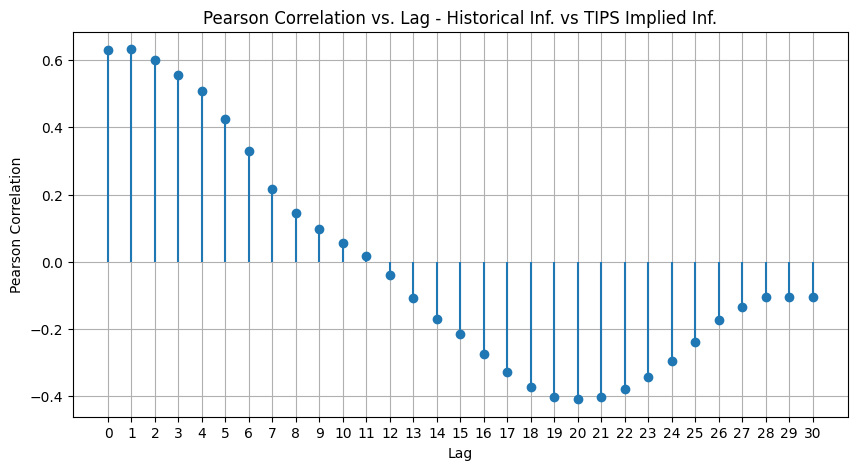

In [12]:
tips_values = merged_df["avg_ann_inf"]
hist_values = merged_df["inflation"]

correlations = {}
for lag in range(31): 
    shifted_tips = tips_values.shift(lag)
    corr = hist_values.corr(shifted_tips)
    correlations[lag] = corr

lags = list(correlations.keys())
corr_values = list(correlations.values())

# Plotting the correlation vs. lags
plt.figure(figsize=(10, 5))
plt.stem(lags, corr_values, basefmt=" ")
plt.title('Pearson Correlation vs. Lag - Historical Inf. vs TIPS Implied Inf.')
plt.xlabel('Lag')
plt.ylabel('Pearson Correlation')
plt.xticks(lags)
plt.grid(True)
plt.show()


TIPS expectation clearly underestimates inflation - Although could is still be a useful predictor in forecasting? It looks correlated and potentially at a lag. This could be an input to a model that tries to forecast inflation.

#### **Credit Spreads**

In [13]:
us_recession = fred.get_series("USREC")
us_recession_df = us_recession.to_frame(name="recession")
us_recession_df = us_recession_df["1919-01-01":]
us_recession_df['start_recession'] = (us_recession_df['recession'] == 1) & (us_recession_df['recession'].shift(1) == 0)
us_recession_df['end_recession'] = (us_recession_df['recession'] == 1) & (us_recession_df['recession'].shift(-1) == 0)

# Initialize variables to hold the start and end of recessions
recession_periods = []
start_date = None

# Identify the start and end dates of recessions
for date, row in us_recession_df.iterrows():
    if row['start_recession']:
        start_date = date
    if row['end_recession'] and start_date is not None:
        end_date = date
        recession_periods.append((start_date, end_date))
        start_date = None  # Reset start_date for the next period
        

In [14]:
aaa = fred.get_series("AAA").to_frame("AAA")
bbb = fred.get_series("BAA").to_frame("BAA")
bonds = pd.concat([aaa,bbb],axis = 1)


In [15]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Assuming the 'bonds' DataFrame is already created and 'recession_periods' is defined

# Create a subplot with 1 row and 1 column
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.1)

# For BAA, use a muted green
fig.add_trace(go.Scatter(
    x=bonds.index, 
    y=bonds["BAA"], 
    mode='lines', 
    name="BAA",
    line=dict(color="#2ca02c")  # A nice shade of green
), row=1, col=1)

# For AAA with shading, use a muted blue and light blue fill
fig.add_trace(go.Scatter(
    x=bonds.index, 
    y=bonds["AAA"], 
    mode='lines', 
    name="AAA",
    fill='tonexty', 
    line=dict(color="#1f77b4"),  # A nice shade of blue
    fillcolor='rgba(31,119,180,0.3)'  # Light blue fill with transparency
), row=1, col=1)

# Update the rest of the figure as you had it, with no other changes.


# Add recession period rectangles if you have them defined
for start, end in recession_periods:
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="red", opacity=0.2,
        layer="below", line_width=0,
        row=1, col=1
    )

# Update the layout of the figure
fig.update_layout(
    title="Moody's Aaa and Baa Index Yields",
    yaxis_title="Yield (%)",
    xaxis_title="Date",
    template="plotly_white",
    legend_title="Bond Type",
    width=1500,
    height=600
)

fig.show()


In [16]:
spread = ((bonds["BAA"] - bonds["AAA"])*100).to_frame("credit_spread")
spread = spread["1947-01-01":]

real_gdp = fred.get_series("GDPC1").to_frame("real_gdp")
real_gdp["real_gdp_lag"] = real_gdp.shift(4)
real_gdp["yoy_change"] = (real_gdp["real_gdp"] / real_gdp["real_gdp_lag"] - 1) * 100
real_gdp.head(10)

us_recession = fred.get_series("USREC")
us_recession_df = us_recession.to_frame(name="recession")
us_recession_df = us_recession_df["1947-01-01":]
us_recession_df['start_recession'] = (us_recession_df['recession'] == 1) & (us_recession_df['recession'].shift(1) == 0)
us_recession_df['end_recession'] = (us_recession_df['recession'] == 1) & (us_recession_df['recession'].shift(-1) == 0)

# Initialize variables to hold the start and end of recessions
recession_periods = []
start_date = None

# Identify the start and end dates of recessions
for date, row in us_recession_df.iterrows():
    if row['start_recession']:
        start_date = date
    if row['end_recession'] and start_date is not None:
        end_date = date
        recession_periods.append((start_date, end_date))
        start_date = None  # Reset start_date for the next period

In [17]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Assuming 'spread' and 'real_gdp' DataFrames are already created

# Create a subplot with 1 row and 1 column with a secondary y-axis
fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

# Trace for Credit Spread, which will use the left y-axis (default)
fig.add_trace(go.Scatter(
    x=spread.index, 
    y=spread["credit_spread"], 
    mode='lines', 
    name="BAA - AAA, Credit Spread",
    line=dict(color="#2ca02c")  # A nice shade of green
), row=1, col=1, secondary_y=False)  # 'secondary_y=False' indicates left y-axis

# Trace for YOY Real GDP Growth as a bar chart, which will use the right y-axis
fig.add_trace(go.Bar(
    x=real_gdp.index, 
    y=real_gdp["yoy_change"], 
    name="YOY Real GDP Growth",
    marker=dict(color="#1f77b4")  # A nice shade of blue
), row=1, col=1, secondary_y=True)  # 'secondary_y=True' indicates right y-axis

# Set the titles for both y-axes
fig.update_yaxes(title_text="Credit Spread (%)", secondary_y=False)
fig.update_yaxes(title_text="YOY Real GDP Growth (%)", secondary_y=True)


# Add recession period rectangles if you have them defined
for start, end in recession_periods:
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="red", opacity=0.2,
        layer="below", line_width=0,
        row=1, col=1
    )


# Update the layout of the figure
fig.update_layout(
    title="Credit Spread vs YOY Real GDP Growth",
    xaxis_title="Date",
    template="plotly_white",
    legend_title="Metric",
    barmode='group',
    width=1500,
    height=600
)

# Show the plot (if running in a Jupyter environment, otherwise use fig.show())
fig.show()


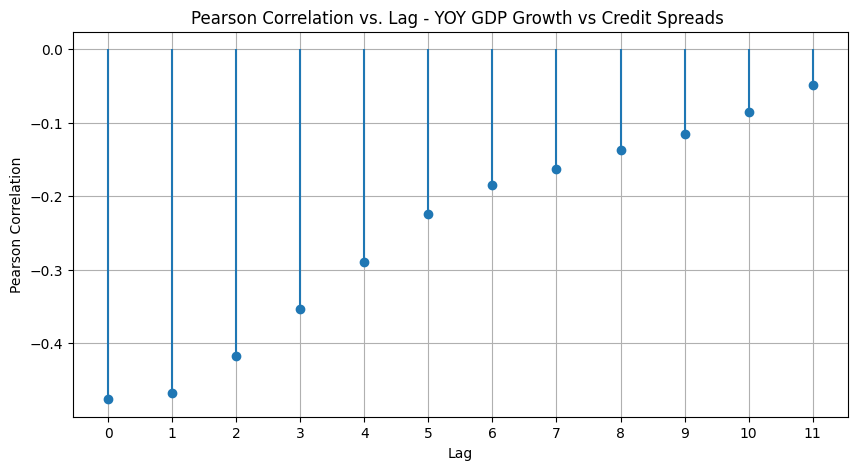

In [18]:
merge = real_gdp.merge(spread, left_index=True, right_index=True, how='inner')
merge = merge.dropna()

growth = merge["yoy_change"]
spreads = merge["credit_spread"]

correlations = {}
for lag in range(12): 
    shifted_growth = growth.shift(lag)
    corr = spreads.corr(shifted_growth)
    correlations[lag] = corr

lags = list(correlations.keys())
corr_values = list(correlations.values())

# Plotting the correlation vs. lags
plt.figure(figsize=(10, 5))
plt.stem(lags, corr_values, basefmt=" ")
plt.title('Pearson Correlation vs. Lag - YOY GDP Growth vs Credit Spreads ')
plt.xlabel('Lag')
plt.ylabel('Pearson Correlation')
plt.xticks(lags)
plt.grid(True)
plt.show()


So what about correlations for a specific time period!

#### **US Inflation vs Unemployment vs GDP Growth**

In [19]:
us_cpi = fred.get_series("CPIAUCNS")
us_cpi_df = us_cpi.to_frame(name = "cpi")
us_cpi_lag = us_cpi_df.shift(12)
us_cpi_lag.rename(columns={'cpi': 'cpi_lag'}, inplace=True)
us_cpi = pd.concat([us_cpi_df,us_cpi_lag],axis = 1)
us_cpi["inflation"] = (us_cpi["cpi"] / us_cpi["cpi_lag"] - 1) *100

inf = us_cpi["inflation"]

real_gdp = fred.get_series("GDPC1").to_frame("real_gdp")
real_gdp["real_gdp_lag"] = real_gdp.shift(4)
real_gdp["yoy_change"] = (real_gdp["real_gdp"] / real_gdp["real_gdp_lag"] - 1) * 100

gdp = real_gdp["yoy_change"]

unemployment_rate = fred.get_series("UNRATE").to_frame(name = "un_rate")

inf_gdp_une = pd.concat([inf,gdp,unemployment_rate], axis = 1)
inf_gdp_une.dropna(inplace=True)

In [20]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a subplot with 1 row and 1 column
fig = make_subplots(rows=1, cols=1)

# Trace for Inflation, line with markers
fig.add_trace(go.Scatter(
    x=inf_gdp_une.index, 
    y=inf_gdp_une["inflation"], 
    mode='lines+markers',  # Line with markers
    name="Inflation",
    line=dict(color="red"),  # Red color for inflation
    marker=dict(color="red", size=6)  # Red markers for clarity
), row=1, col=1)

# Trace for YOY Real GDP Growth as a bar chart
fig.add_trace(go.Bar(
    x=inf_gdp_une.index, 
    y=inf_gdp_une["yoy_change"],
    name="YOY Real GDP Growth",
    marker=dict(color="#2ca02c", opacity=0.7)  # Slightly transparent green bars
), row=1, col=1)

# Trace for Unemployment Rate, line with markers
fig.add_trace(go.Scatter(
    x=inf_gdp_une.index, 
    y=inf_gdp_une["un_rate"],
    mode='lines+markers',  # Line with markers
    name="Unemployment Rate",
    line=dict(color="orange"),  # Orange line for visibility
    marker=dict(color="orange", size=8)  # Larger orange markers
), row=1, col=1)


for start, end in recession_periods:
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="red", opacity=0.2,
        layer="below", line_width=0,
        row=1, col=1
    )




# Set the title for y-axis
fig.update_yaxes(title_text="Percentage (%)")

# Set overall layout title and layout adjustments
fig.update_layout(
    title="Inflation, GDP Growth, and Unemployment Rate",
    xaxis_title="Date",
    legend=dict(
        bordercolor="Black",
        borderwidth=1
    )
)

fig.show()
